In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting

from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots #for partial plots

np.random.seed(123) #ensure reproducibility
pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [23]:
'''
age: age
sex: sex
cp: chest pain type (4 values)
trtbps: resting blood pressure
chol: serum cholestoral in mg/dl
fbs: fasting blood sugar > 120 mg/dl
restecg: resting electrocardiographic results (values 0,1,2)
thalachh: maximum heart rate achieved
exng: exercise induced angina
oldpeak: oldpeak = ST depression induced by exercise relative to rest
slp: the slope of the peak exercise ST segment
caa: number of major vessels (0-3) colored by flourosopy
thall: thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
'''

heart = pd.read_csv('https://raw.githubusercontent.com/DanielBrooks253/Kaggle/main/Heart_Attack_Analysis/heart.csv')
heart['cp'].replace({1: 'typical_angina', 2: 'atypical_angina', 3: 'non-anginal_pain', 4: 'asymptomatic', 0:'other'}, inplace=True)
heart['restecg'].replace({0:'normal', 1:'ST-T_wave_abnormality', 2:'signs_of_hypertrophy'}, inplace=True)
heart['slp'].replace({0:'upsloping', 1:'flat', 2:'downsloping'}, inplace=True)
heart['exng'].replace({0: 'no', 1:'yes'}, inplace=True)
heart['thall'].replace({1:'normal', 2:'fixed_defect', 3:'reversable_defect', 0:'other'}, inplace=True)
heart['sex'].replace({0:'male', 1:'female'}, inplace=True)
heart['fbs'].replace({0:'lower_120mg/dl', 1:'greater_120mg/dl'}, inplace=True)

heart['caa'] = heart['caa'].astype('object')

heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,female,non-anginal_pain,145,233,greater_120mg/dl,normal,150,no,2.3,upsloping,0,normal,1
1,37,female,atypical_angina,130,250,lower_120mg/dl,ST-T_wave_abnormality,187,no,3.5,upsloping,0,fixed_defect,1
2,41,male,typical_angina,130,204,lower_120mg/dl,normal,172,no,1.4,downsloping,0,fixed_defect,1
3,56,female,typical_angina,120,236,lower_120mg/dl,ST-T_wave_abnormality,178,no,0.8,downsloping,0,fixed_defect,1
4,57,male,other,120,354,lower_120mg/dl,ST-T_wave_abnormality,163,yes,0.6,downsloping,0,fixed_defect,1


<BarContainer object of 2 artists>

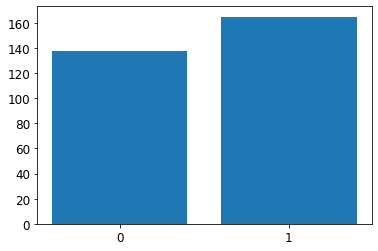

In [24]:
dt = pd.get_dummies(heart, drop_first=True)
counts = {"0": len(heart[heart['output'] == 0]), 
          "1": len(heart[heart['output'] == 1])}

plt.bar(counts.keys(), counts.values()) # Pretty even split

<AxesSubplot:>

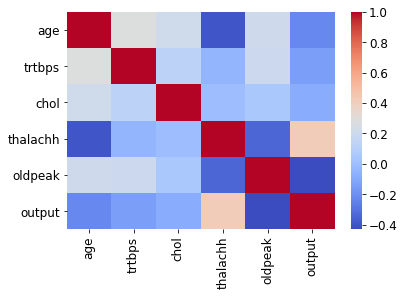

In [25]:
sns.heatmap(heart.corr(),cmap='coolwarm')

In [26]:
dt.head()

,age,trtbps,chol,thalachh,oldpeak,output,sex_male,cp_non-anginal_pain,cp_other,cp_typical_angina,...,exng_yes,slp_flat,slp_upsloping,caa_1,caa_2,caa_3,caa_4,thall_normal,thall_other,thall_reversable_defect
0,63,145,233,150,2.3,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,41,130,204,172,1.4,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,56,120,236,178,0.8,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,57,120,354,163,0.6,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('output', axis=1),
                                                    dt['output'],
                                                    test_size=.25, 
                                                    random_state=1234)

# Random Forest Approach

In [28]:
model = RandomForestClassifier(max_depth=5, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [29]:
estimator = model.estimators_[0]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

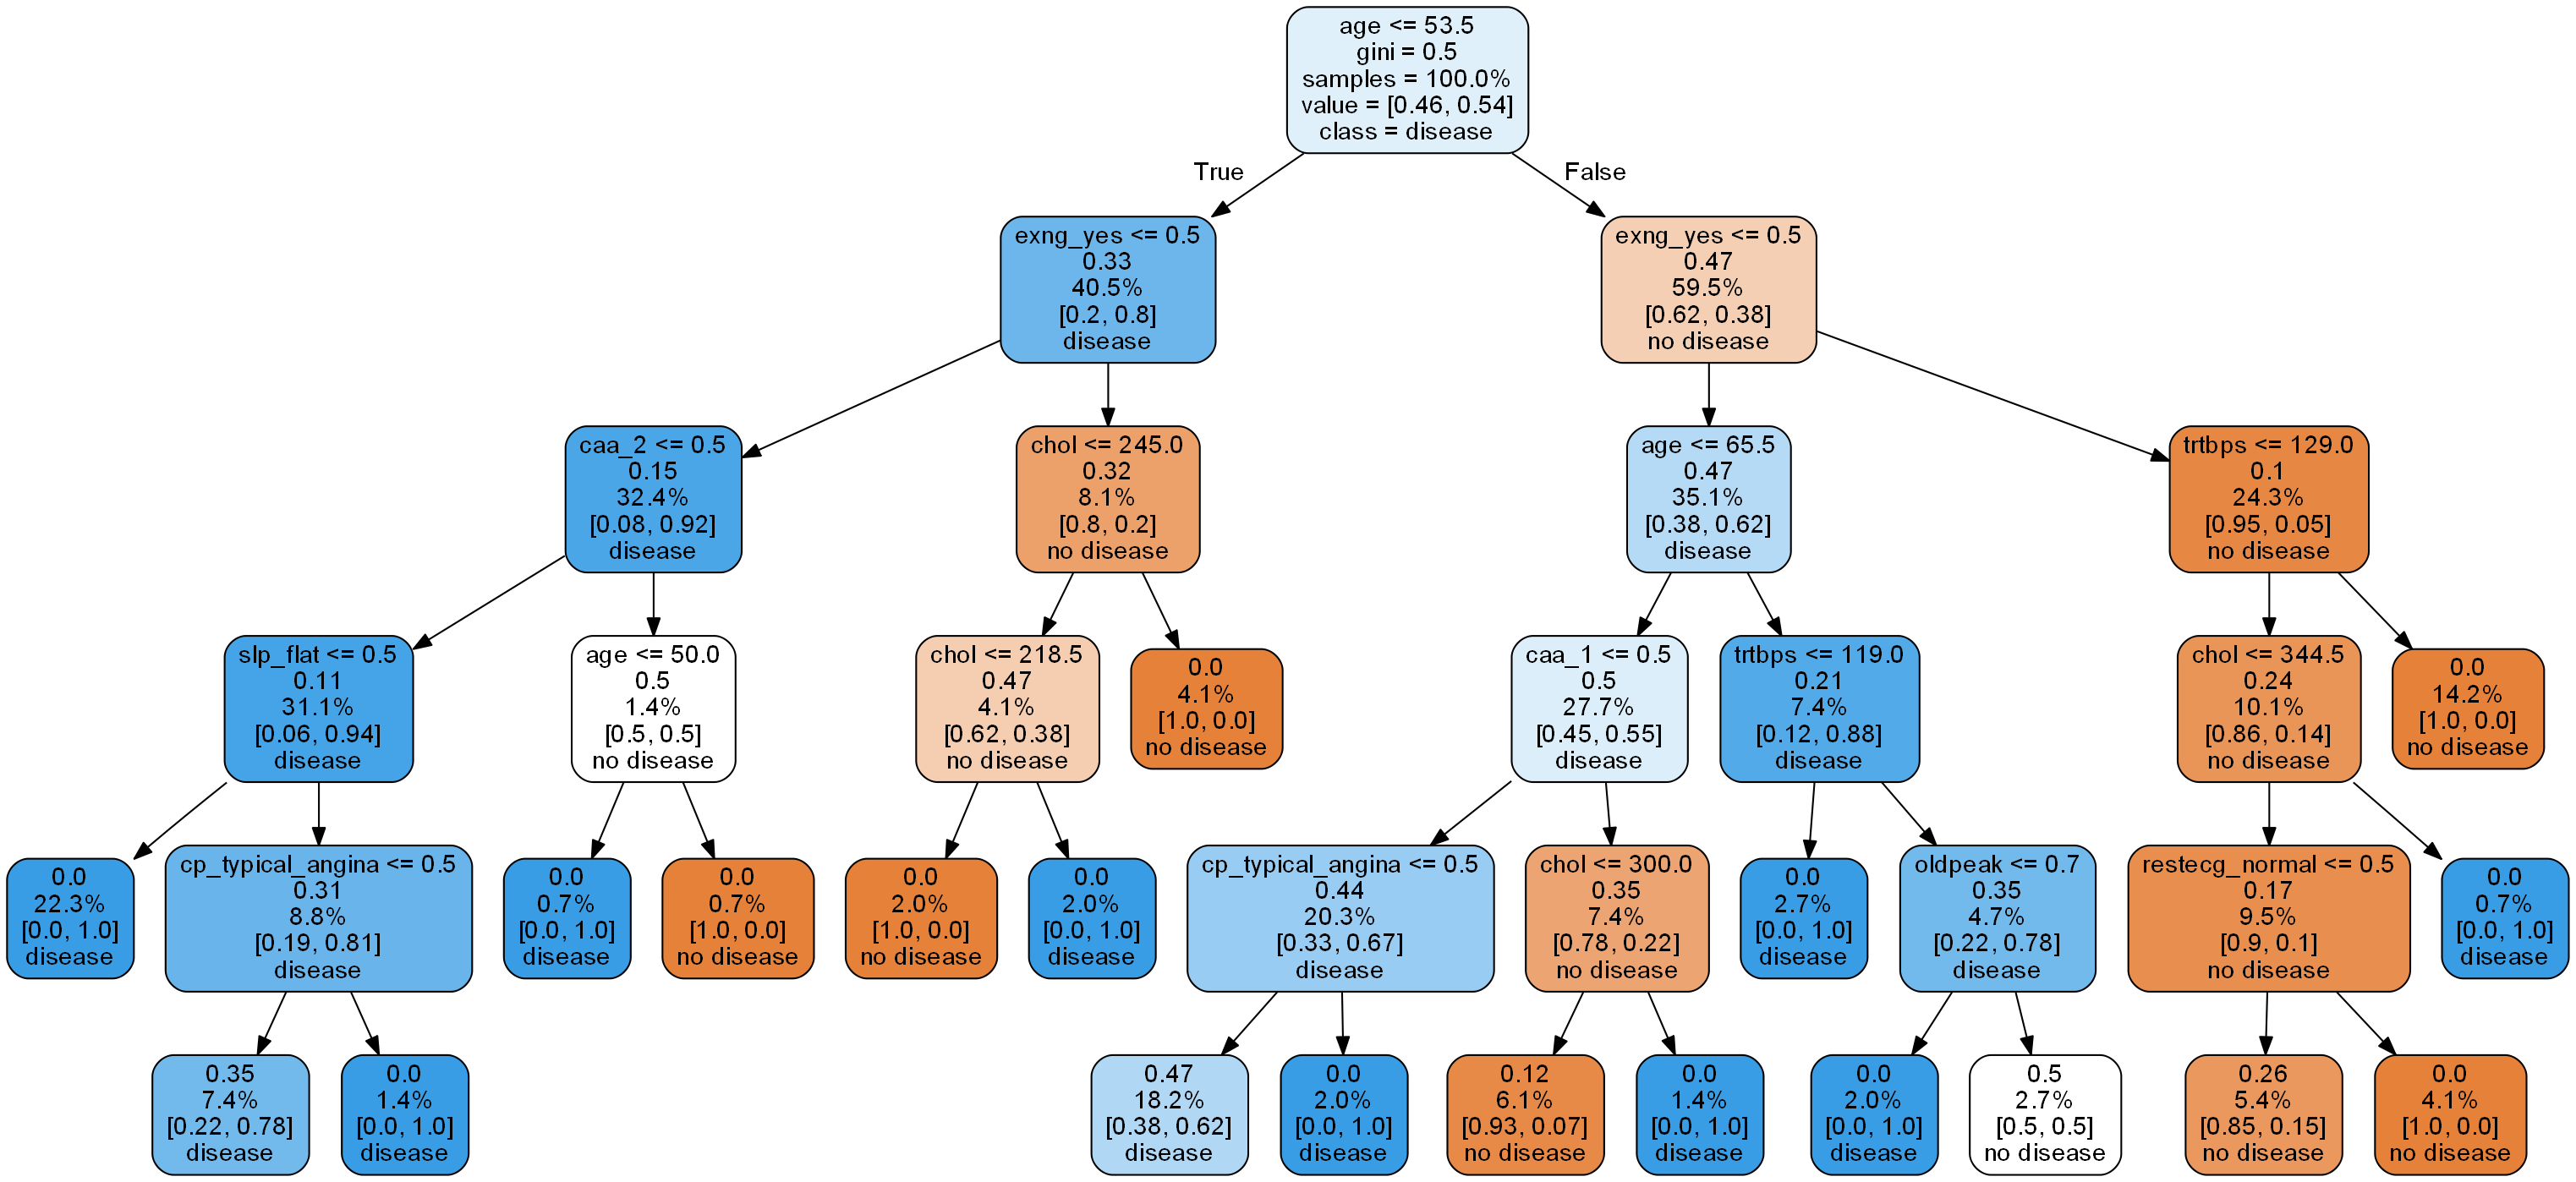

In [30]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/daniel.brooks/Anaconda3/Library/bin/graphviz'

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

from IPython.display import Image
Image(filename = 'tree.png')

In [31]:
y_predict = pd.Series(model.predict(X_test))
y_pred_quant = model.predict_proba(X_test)[:, 1]

y_predict.replace({0:'no disease', 1:'disease'}, inplace=True)

In [32]:
pd.crosstab(y_test.replace({0:'no disease', 1:'disease'}), y_predict.values, rownames=['Predcition'], colnames=['Acutal'])

Acutal,disease,no disease
Predcition,,
disease,38,4
no disease,11,23


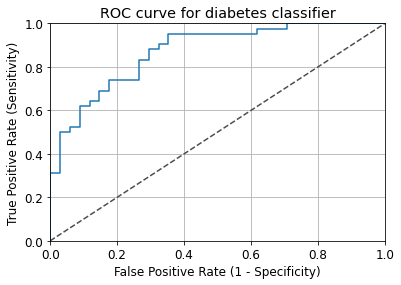

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [34]:
auc(fpr, tpr)

0.8711484593837535

In [35]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0658 ± 0.0440,cp_other
0.0342 ± 0.0268,exng_yes
0.0316 ± 0.0268,oldpeak
0.0237 ± 0.0307,thall_reversable_defect
0.0184 ± 0.0211,sex_male
0.0132 ± 0.0288,caa_1
0.0079 ± 0.0357,thalachh
0.0053 ± 0.0211,age
0.0053 ± 0.0129,caa_3
0.0026 ± 0.0197,trtbps


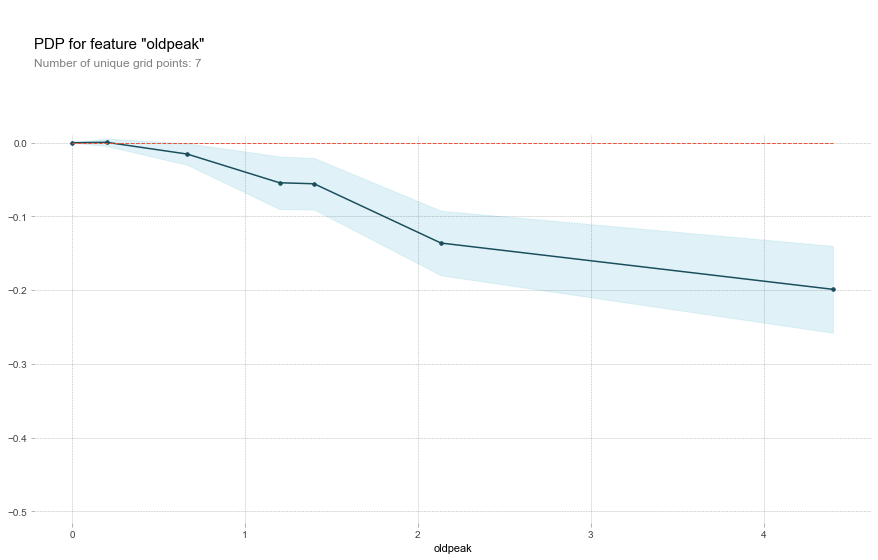

In [36]:
base_features = dt.columns.values.tolist()
base_features.remove('output')

feat_name = 'oldpeak'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

# Naive Bayes Approach

In [37]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

continuous = heart[['age', 'thalachh', 'oldpeak', 'trtbps', 'chol']]
categories = heart.drop(['age', 'thalachh', 'oldpeak', 'trtbps', 'chol', 'output'], axis=1)

enc = OrdinalEncoder()
factor_data = enc.fit_transform(np.array(categories))

In [40]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(factor_data,
                                                                    heart['output'],
                                                                    test_size=.25, 
                                                                    random_state=1234)

cat_nb = CategoricalNB()
cat_nb.fit(X_train_cat, y_train_cat)

CategoricalNB()

In [47]:
preds = pd.Series(cat_nb.predict(X_test_cat)).replace({0:'no disease', 1:'disease'})
preds_quant = cat_nb.predict_proba(X_test_cat)[:, 1]

pd.crosstab(y_test.replace({0:'no disease', 1:'disease'}), preds.values, rownames=['Predcition'], colnames=['Acutal'])

Acutal,disease,no disease
Predcition,,
disease,37,5
no disease,10,24


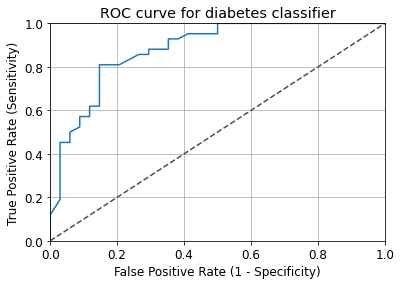

In [48]:
fpr, tpr, thresholds = roc_curve(y_test_cat, preds_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [49]:
auc(fpr, tpr)

0.8806022408963585